In [1]:
# 匯入/處理/裁切圖片 getting numpy arrays of pixel values of images.
import os # use directory & join path
import cv2 #opencv library read img operations                  
import numpy as np # array operations
 
# data visualisation and manipulation
import matplotlib.pyplot as plt #show img and table
from tqdm import tqdm # loading img 進度條  

In [2]:
#Tensorflow Keras DNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop,Adamax,Nadam
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding (數值ex.5 >> 00001) 

In [3]:
# Splitting train set to train data set and test data set
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing

# model 混淆矩陣分析
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay #混淆矩陣(Confusion matrix)分析

In [4]:
import random
from random import shuffle # 產生隨機 list，用於印出測試集隨機十筆預測後的結果和正解進行比較

In [5]:
DATADIR = 'flowers/'
CATEGORIES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

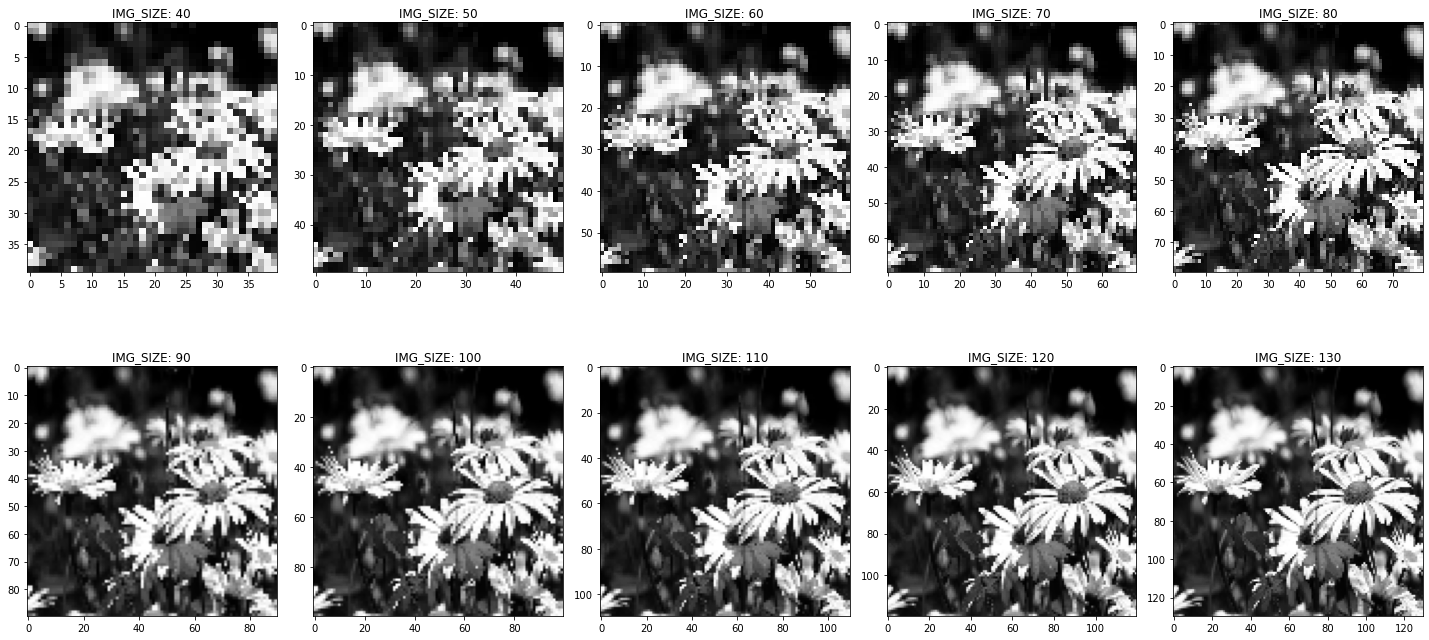

In [6]:
# 找適合的圖片壓縮大小 (圖片不會太糊的最小值) 結論：設 IMG_SIZE = 100
row=2
col=5
index=0
IMG_SIZE_OPTION=[40,50,60,70,80,90,100,110,120,130,140]
path_temp = os.path.join(DATADIR,CATEGORIES[0])
path_temp = path_temp + '/'+ os.listdir(path_temp)[5]

img_temp = cv2.imread(path_temp ,cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(row, col)
fig.set_size_inches(20, 10)
for r in range(row):
    for c in range(col):
        new_array = cv2.resize(img_temp, (IMG_SIZE_OPTION[index], IMG_SIZE_OPTION[index]))
        ax[r, c].imshow(new_array, cmap='gray')   
        ax[r, c].set_title(f'IMG_SIZE: {IMG_SIZE_OPTION[index]}')
        index = index+1
plt.tight_layout()


In [7]:
IMG_SIZE = 100
training_data = []

for category in CATEGORIES:  # 依序進每個花的資料夾抓圖片 ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

    path = os.path.join(DATADIR,category)  # create path to every categories

    class_num = CATEGORIES.index(category)  # get the classification  (0:daisy 1:dandelion 2:rose 3:sunflower 4:tulip)

    for img in tqdm(os.listdir(path)):  # os.listdir(path): 列出資料夾下每張圖的檔名，抓到每張圖的檔案 path 
        try:
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert img to array 以灰階格是讀取(二維)
            img_resize_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size 圖片統一100px*100px
            img_resize_array=img_resize_array / 255 # transform img num 0~1

            training_data.append([img_resize_array, class_num])  # 將圖片加進 training_data
            
        except Exception as e:  # in the interest in keeping the output clean...
            pass # 略過錯誤

100%|██████████████████████████████████████████████████████████████████████████████| 984/984 [00:00<00:00, 1010.09it/s]


In [8]:
X = [] # save image data feature
y = [] # save target : flower label

for features,label in training_data:
    X.append(np.array(features))
    y.append(np.array(label))
    
# 將 flower label 轉換 1:[1. 0. 0. 0. 0.] / 2:[0. 1. 0. 0. 0.] / 3:[0. 0. 1. 0. 0.] / 4:[0. 0. 0. 1. 0.] / 5:[0. 0. 0. 0. 1.]
y_TrainOneHot = np_utils.to_categorical(y) 

# 將 training_data 的 input 資料轉為2維
X_arr = np.array(X).reshape(4317, IMG_SIZE * IMG_SIZE).astype('float32')
y_arr = np.array(y_TrainOneHot)

print(X_arr.shape)
print(y_arr.shape)

# Splitting train set to train data set and test data set
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_arr, y_arr, random_state=32, test_size=0.2)


(4317, 10000)
(4317, 5)


In [9]:
def plot_history(history, loss=True):

    num_epochs = len(history['loss'])
    title = 'loss' if loss else 'accuracy'
    plt.title(f'Train Validation {title}')
    plt.plot(range(1, num_epochs+1), history[f'{title}'], label='Train')
    plt.plot(range(1, num_epochs+1), history[f'val_{title}'], label='Validation')
    plt.xlabel('Trainig Epochs')
    plt.ylabel(title)
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
# 設 訓練週期  & 批次大小
epochsNum = 40 
batch_sizeNum = 16

In [11]:
# Define Network
# 建立簡單的線性執行的模型 
# lr: float >= 0. 學習率。
# beta_1: float, 0 < beta < 1. 通常接近於 1。
# beta_2: float, 0 < beta < 1. 通常接近於 1。
# epsilon: float >= 0. 模糊因子. 若為 None, 默認為 K.epsilon()。
# decay: float >= 0. 每次参數更新後學習率衰减值。
# amsgrad: boolean. 是否應用此算法的 AMSGrad 變種，来自論文 "On the Convergence of Adam and Beyond"。
# Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

Adam_model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
Adam_model.add(Dense(units=256, input_dim=10000, kernel_initializer='normal', activation='relu')) 
# Add output layer
Adam_model.add(Dense(units=5, kernel_initializer='normal', activation='softmax'))

In [12]:
# Compile Network
# 編譯: 選擇損失函數、優化方法及成效衡量方式
# For a multi-class classification problem
# 優化器 Adam 學習率： 固定 0.0001
Adam_model.compile( optimizer = Adam(learning_rate=0.0001),
                           loss = 'categorical_crossentropy',  
                           metrics = ['accuracy'] ) 
Adam_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560256   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,561,541
Trainable params: 2,561,541
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fit Network
# Train the model 批次 = 40 訓練週期 = 16
Adam_hostory = Adam_model.fit(
                    x = X_arr, 
                    y = y_arr,
                    validation_data = (x_test, y_test),
                    epochs = epochsNum, 
                    batch_size = batch_sizeNum, 
                    shuffle = True, 
                    verbose = 2)

Epoch 1/40
270/270 - 2s - loss: 1.6471 - accuracy: 0.2738 - val_loss: 1.5176 - val_accuracy: 0.3148 - 2s/epoch - 8ms/step
Epoch 2/40
270/270 - 2s - loss: 1.5481 - accuracy: 0.3218 - val_loss: 1.4873 - val_accuracy: 0.3611 - 2s/epoch - 7ms/step
Epoch 3/40
270/270 - 2s - loss: 1.5079 - accuracy: 0.3387 - val_loss: 1.4165 - val_accuracy: 0.3981 - 2s/epoch - 7ms/step
Epoch 4/40
270/270 - 2s - loss: 1.4711 - accuracy: 0.3660 - val_loss: 1.4180 - val_accuracy: 0.3924 - 2s/epoch - 7ms/step
Epoch 5/40
270/270 - 2s - loss: 1.4632 - accuracy: 0.3651 - val_loss: 1.3848 - val_accuracy: 0.4144 - 2s/epoch - 7ms/step
Epoch 6/40
270/270 - 2s - loss: 1.4134 - accuracy: 0.3917 - val_loss: 1.3834 - val_accuracy: 0.4433 - 2s/epoch - 7ms/step
Epoch 7/40
270/270 - 2s - loss: 1.3791 - accuracy: 0.4200 - val_loss: 1.3931 - val_accuracy: 0.4572 - 2s/epoch - 7ms/step
Epoch 8/40
270/270 - 2s - loss: 1.3547 - accuracy: 0.4357 - val_loss: 1.3025 - val_accuracy: 0.5104 - 2s/epoch - 7ms/step
Epoch 9/40
270/270 - 2s 

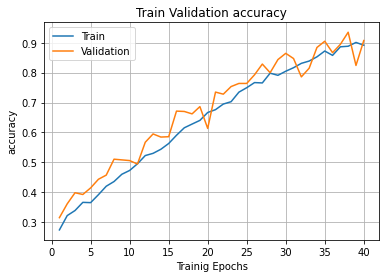

In [14]:
# Train validation accuracy
plot_history(Adam_hostory.history, False)

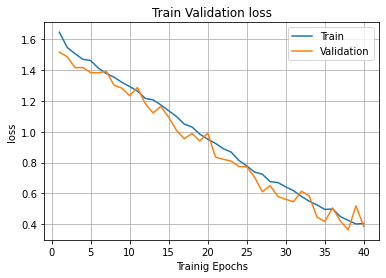

In [15]:
# Train validation loss 
plot_history(Adam_hostory.history, True)

In [16]:
# Define Network
# 建立簡單的線性執行的模型 
SGD_model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
SGD_model.add(Dense(units = 256, input_dim = 10000, kernel_initializer = 'normal', activation = 'relu')) 
# Add output layer
SGD_model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'softmax'))

In [17]:
# Compile Network

# 優化器 SGD 學習率： 固定 0.01
# momentum: float >= 0. 参数，用於加速 SGD 在相關方向上前進，並抑制震盪。
# decay: float >= 0. 每次参數更新後學習率衰减值。
# nesterov: boolean. 是否使用 Nesterov 動量。

SGD_model.compile( optimizer=SGD(learning_rate = 0.01, momentum = 0.0, decay = 0.0, nesterov = False),
                           loss = 'categorical_crossentropy',  
                           metrics = ['accuracy'] ) 
SGD_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2560256   
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,561,541
Trainable params: 2,561,541
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit Network
# Train the model 批次 = 40 訓練週期 = 16
SGD_hostory = SGD_model.fit(
                    x = X_arr, 
                    y = y_arr,
                    validation_data = (x_test, y_test),
                    epochs = epochsNum, 
                    batch_size = batch_sizeNum, 
                    shuffle = True, 
                    verbose = 2)

Epoch 1/40
270/270 - 1s - loss: 1.5992 - accuracy: 0.2833 - val_loss: 1.4845 - val_accuracy: 0.3449 - 1s/epoch - 5ms/step
Epoch 2/40
270/270 - 1s - loss: 1.4858 - accuracy: 0.3433 - val_loss: 1.4560 - val_accuracy: 0.3646 - 1s/epoch - 4ms/step
Epoch 3/40
270/270 - 1s - loss: 1.4516 - accuracy: 0.3658 - val_loss: 1.4415 - val_accuracy: 0.3727 - 1s/epoch - 4ms/step
Epoch 4/40
270/270 - 1s - loss: 1.4272 - accuracy: 0.3811 - val_loss: 1.3989 - val_accuracy: 0.4167 - 1s/epoch - 4ms/step
Epoch 5/40
270/270 - 1s - loss: 1.4013 - accuracy: 0.4056 - val_loss: 1.4103 - val_accuracy: 0.3785 - 1s/epoch - 4ms/step
Epoch 6/40
270/270 - 1s - loss: 1.3779 - accuracy: 0.4204 - val_loss: 1.3859 - val_accuracy: 0.4062 - 1s/epoch - 4ms/step
Epoch 7/40
270/270 - 1s - loss: 1.3519 - accuracy: 0.4327 - val_loss: 1.3229 - val_accuracy: 0.4688 - 1s/epoch - 4ms/step
Epoch 8/40
270/270 - 1s - loss: 1.3306 - accuracy: 0.4515 - val_loss: 1.2951 - val_accuracy: 0.4826 - 1s/epoch - 4ms/step
Epoch 9/40
270/270 - 1s 

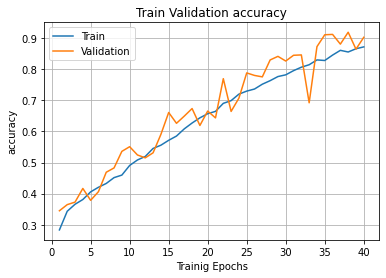

In [19]:
# Train validation accuracy
plot_history(SGD_hostory.history, False)

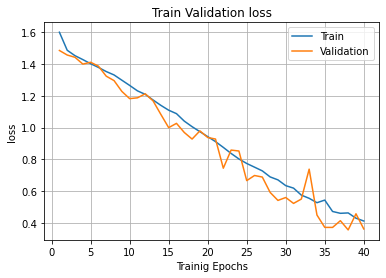

In [20]:
# Train validation loss 
plot_history(SGD_hostory.history, True)

In [21]:
# Define Network
# 建立簡單的線性執行的模型 
RMSprop_model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
RMSprop_model.add(Dense(units = 256, input_dim = 10000, kernel_initializer = 'normal', activation = 'relu')) 
# Add output layer
RMSprop_model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'softmax'))

In [22]:
# Compile Network

# 優化器 RMSprop 學習率： 固定 0.001
# lr: float >= 0. 學習率。
# rho: float >= 0. RMSProp梯度平方的移動均值的衰减率.
# epsilon: float >= 0. 模糊因子. 若為 None, 默認为 K.epsilon()。
# decay: float >= 0. 每次参數更新後學習率衰减值。

RMSprop_model.compile( optimizer=RMSprop(learning_rate = 0.001, rho = 0.9, epsilon = None, decay = 0.0),
                           loss = 'categorical_crossentropy',  
                           metrics = ['accuracy'] ) 
RMSprop_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               2560256   
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,561,541
Trainable params: 2,561,541
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Fit Network
# Train the model 批次 = 40 訓練週期 = 27
RMSprop_hostory = RMSprop_model.fit(
                    x = X_arr, 
                    y = y_arr,
                    validation_data = (x_test, y_test),
                    epochs = 25, 
                    batch_size = batch_sizeNum, 
                    shuffle = True, 
                    verbose = 2)

Epoch 1/27
270/270 - 4s - loss: 2.6803 - accuracy: 0.2469 - val_loss: 1.5671 - val_accuracy: 0.2535 - 4s/epoch - 16ms/step
Epoch 2/27
270/270 - 4s - loss: 1.5936 - accuracy: 0.2745 - val_loss: 1.5705 - val_accuracy: 0.2500 - 4s/epoch - 14ms/step
Epoch 3/27
270/270 - 4s - loss: 1.5522 - accuracy: 0.2988 - val_loss: 1.4969 - val_accuracy: 0.3507 - 4s/epoch - 14ms/step
Epoch 4/27
270/270 - 4s - loss: 1.5216 - accuracy: 0.3157 - val_loss: 1.5858 - val_accuracy: 0.3056 - 4s/epoch - 14ms/step
Epoch 5/27
270/270 - 4s - loss: 1.5188 - accuracy: 0.3187 - val_loss: 1.4703 - val_accuracy: 0.3484 - 4s/epoch - 14ms/step
Epoch 6/27
270/270 - 4s - loss: 1.4977 - accuracy: 0.3329 - val_loss: 1.4592 - val_accuracy: 0.3495 - 4s/epoch - 14ms/step
Epoch 7/27
270/270 - 4s - loss: 1.4894 - accuracy: 0.3375 - val_loss: 1.4352 - val_accuracy: 0.3831 - 4s/epoch - 15ms/step
Epoch 8/27
270/270 - 4s - loss: 1.4706 - accuracy: 0.3482 - val_loss: 1.4169 - val_accuracy: 0.3947 - 4s/epoch - 15ms/step
Epoch 9/27
270/2

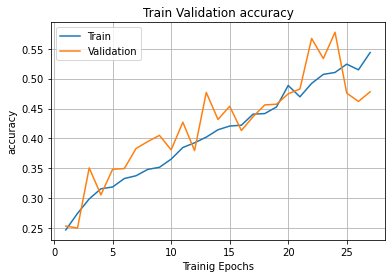

In [24]:
# Train validation accuracy
plot_history(RMSprop_hostory.history, False)

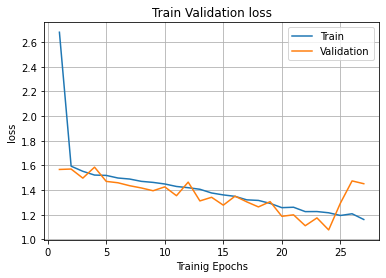

In [25]:
# Train validation loss 
plot_history(RMSprop_hostory.history, True)

In [26]:
# Define Network
# 建立簡單的線性執行的模型 
Adagrad_model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
Adagrad_model.add(Dense(units=256, input_dim=10000, kernel_initializer='normal', activation='relu')) 
# Add output layer
Adagrad_model.add(Dense(units=5, kernel_initializer='normal', activation='softmax'))

In [27]:
# Compile Network

# 優化器 Adagrad 學習率： 固定 0.01
# lr: float >= 0. 學習率。
# epsilon: float >= 0. 模糊因子. 若為 None, 默認为 K.epsilon()。
# decay: float >= 0. 每次参數更新後學習率衰减值。

Adagrad_model.compile( optimizer=Adagrad(learning_rate=0.01, epsilon=None, decay=0.0),
                           loss='categorical_crossentropy',  
                           metrics=['accuracy'] ) 
Adagrad_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               2560256   
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,561,541
Trainable params: 2,561,541
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fit Network
# Train the model 批次 = 40 訓練週期 = 27
Adagrad_hostory = Adagrad_model.fit(
                    x = X_arr, 
                    y = y_arr,
                    validation_data = (x_test, y_test),
                    epochs = 27, 
                    batch_size = batch_sizeNum, 
                    shuffle = True, 
                    verbose = 2)

Epoch 1/27
270/270 - 2s - loss: 1.6033 - accuracy: 0.2845 - val_loss: 1.5122 - val_accuracy: 0.3125 - 2s/epoch - 7ms/step
Epoch 2/27
270/270 - 2s - loss: 1.4972 - accuracy: 0.3326 - val_loss: 1.4805 - val_accuracy: 0.3623 - 2s/epoch - 6ms/step
Epoch 3/27
270/270 - 2s - loss: 1.4729 - accuracy: 0.3454 - val_loss: 1.4398 - val_accuracy: 0.3738 - 2s/epoch - 6ms/step
Epoch 4/27
270/270 - 2s - loss: 1.4412 - accuracy: 0.3755 - val_loss: 1.4266 - val_accuracy: 0.3900 - 2s/epoch - 6ms/step
Epoch 5/27
270/270 - 2s - loss: 1.4119 - accuracy: 0.3973 - val_loss: 1.3857 - val_accuracy: 0.4086 - 2s/epoch - 6ms/step
Epoch 6/27
270/270 - 2s - loss: 1.3843 - accuracy: 0.4144 - val_loss: 1.3143 - val_accuracy: 0.4873 - 2s/epoch - 6ms/step
Epoch 7/27
270/270 - 2s - loss: 1.3554 - accuracy: 0.4385 - val_loss: 1.2951 - val_accuracy: 0.4931 - 2s/epoch - 6ms/step
Epoch 8/27
270/270 - 2s - loss: 1.3253 - accuracy: 0.4628 - val_loss: 1.2739 - val_accuracy: 0.4919 - 2s/epoch - 6ms/step
Epoch 9/27
270/270 - 2s 

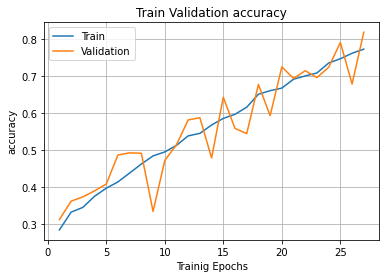

In [29]:
# Train validation accuracy
plot_history(Adagrad_hostory.history, False)

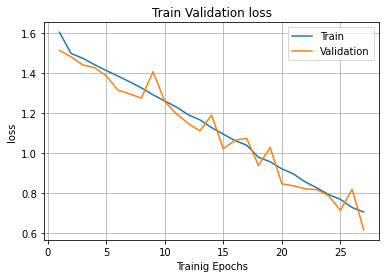

In [30]:
# Train validation loss 
plot_history(Adagrad_hostory.history, True)

In [31]:
# Define Network
# 建立簡單的線性執行的模型 
Adadelta_model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
Adadelta_model.add(Dense(units = 256, input_dim = 10000, kernel_initializer = 'normal', activation = 'relu')) 
# Add output layer
Adadelta_model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'softmax'))

In [32]:
# Compile Network

# 優化器 Adadelta
# lr: float >= 0. 學習率。 學習率： 固定 1.0
# rho: float >= 0. Adadelta梯度平方移動均值的衰减率。
# epsilon: float >= 0. 模糊因子. 若為 None, 默認为 K.epsilon()。
# decay: float >= 0. 每次参數更新後學習率衰减值。

Adadelta_model.compile( optimizer = Adadelta(learning_rate = 1.0, rho = 0.95, epsilon = None, decay = 0.0),
                           loss = 'categorical_crossentropy',  
                           metrics = ['accuracy'] ) 
Adadelta_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               2560256   
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,561,541
Trainable params: 2,561,541
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Fit Network
# Train the model 批次=16 訓練週期=35
Adadelta_hostory = Adadelta_model.fit(
                    x = X_arr, 
                    y = y_arr,
                    validation_data = (x_test, y_test),
                    epochs = 35, 
                    batch_size = batch_sizeNum, 
                    shuffle = True, 
                    verbose = 2)

Epoch 1/35
270/270 - 2s - loss: 1.7557 - accuracy: 0.2713 - val_loss: 1.5482 - val_accuracy: 0.2824 - 2s/epoch - 9ms/step
Epoch 2/35
270/270 - 2s - loss: 1.5470 - accuracy: 0.2944 - val_loss: 1.5405 - val_accuracy: 0.2882 - 2s/epoch - 8ms/step
Epoch 3/35
270/270 - 2s - loss: 1.5294 - accuracy: 0.3055 - val_loss: 1.5053 - val_accuracy: 0.3345 - 2s/epoch - 8ms/step
Epoch 4/35
270/270 - 2s - loss: 1.5255 - accuracy: 0.3213 - val_loss: 1.4707 - val_accuracy: 0.3565 - 2s/epoch - 7ms/step
Epoch 5/35
270/270 - 2s - loss: 1.5069 - accuracy: 0.3241 - val_loss: 1.4872 - val_accuracy: 0.3345 - 2s/epoch - 7ms/step
Epoch 6/35
270/270 - 2s - loss: 1.4867 - accuracy: 0.3477 - val_loss: 1.4900 - val_accuracy: 0.3715 - 2s/epoch - 7ms/step
Epoch 7/35
270/270 - 2s - loss: 1.4752 - accuracy: 0.3535 - val_loss: 1.4202 - val_accuracy: 0.4051 - 2s/epoch - 7ms/step
Epoch 8/35
270/270 - 2s - loss: 1.4474 - accuracy: 0.3662 - val_loss: 1.4184 - val_accuracy: 0.3773 - 2s/epoch - 7ms/step
Epoch 9/35
270/270 - 2s 

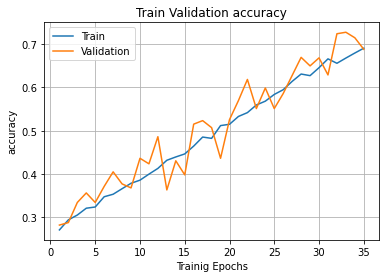

In [34]:
# Train validation accuracy
plot_history(Adadelta_hostory.history, False)

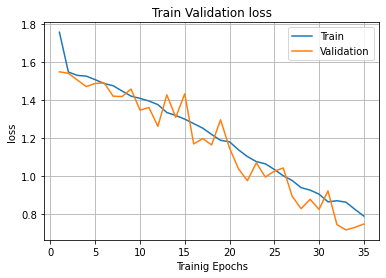

In [35]:
# Train validation loss 
plot_history(Adadelta_hostory.history, True)

In [36]:
# Define Network
# 建立簡單的線性執行的模型 
Adamax_model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
Adamax_model.add(Dense(units = 256, input_dim = 10000, kernel_initializer = 'normal', activation = 'relu')) 
# Add output layer
Adamax_model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'softmax'))

In [37]:
# Compile Network

# 優化器 Adamax
# lr: float >= 0. 學習率。
# beta_1/beta_2: floats, 0 < beta < 1. 通常接近於 1。
# epsilon: float >= 0. 模糊因子. 若為 None, 默認为 K.epsilon()。
# decay: float >= 0. 每次参數更新後學習率衰减值。

Adamax_model.compile( optimizer = Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0),
                           loss = 'categorical_crossentropy',  
                           metrics = ['accuracy'] ) 
Adamax_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               2560256   
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 2,561,541
Trainable params: 2,561,541
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Fit Network
# Train the model 批次 = 16 訓練週期 = 40
Adamax_hostory = Adamax_model.fit(
                    x = X_arr, 
                    y = y_arr,
                    validation_data = (x_test, y_test),
                    epochs = epochsNum, 
                    batch_size = batch_sizeNum, 
                    shuffle = True, 
                    verbose = 2)

Epoch 1/40
270/270 - 2s - loss: 2.1488 - accuracy: 0.2601 - val_loss: 1.4858 - val_accuracy: 0.3414 - 2s/epoch - 8ms/step
Epoch 2/40
270/270 - 2s - loss: 1.6097 - accuracy: 0.2965 - val_loss: 1.4916 - val_accuracy: 0.3241 - 2s/epoch - 7ms/step
Epoch 3/40
270/270 - 2s - loss: 1.5541 - accuracy: 0.3095 - val_loss: 1.4938 - val_accuracy: 0.3368 - 2s/epoch - 7ms/step
Epoch 4/40
270/270 - 2s - loss: 1.5170 - accuracy: 0.3236 - val_loss: 1.4804 - val_accuracy: 0.3183 - 2s/epoch - 7ms/step
Epoch 5/40
270/270 - 2s - loss: 1.4999 - accuracy: 0.3384 - val_loss: 1.4942 - val_accuracy: 0.3206 - 2s/epoch - 7ms/step
Epoch 6/40
270/270 - 2s - loss: 1.4909 - accuracy: 0.3377 - val_loss: 1.4498 - val_accuracy: 0.4086 - 2s/epoch - 7ms/step
Epoch 7/40
270/270 - 2s - loss: 1.4739 - accuracy: 0.3424 - val_loss: 1.4284 - val_accuracy: 0.3785 - 2s/epoch - 7ms/step
Epoch 8/40
270/270 - 2s - loss: 1.4523 - accuracy: 0.3706 - val_loss: 1.3934 - val_accuracy: 0.4329 - 2s/epoch - 7ms/step
Epoch 9/40
270/270 - 2s 

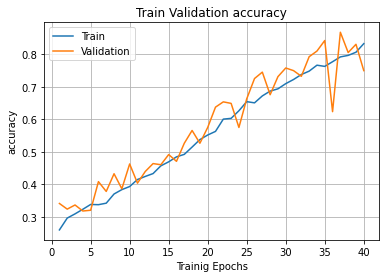

In [39]:
# Train validation accuracy
plot_history(Adamax_hostory.history, False)

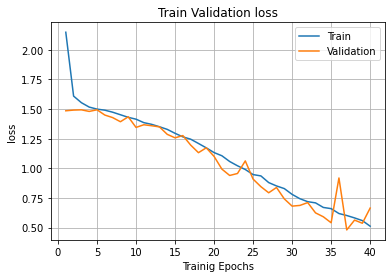

In [40]:
# Train validation loss 
plot_history(Adamax_hostory.history, True)

In [41]:
# Define Network
# 建立簡單的線性執行的模型 
Nadam_model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
Nadam_model.add(Dense(units = 256, input_dim = 10000, kernel_initializer = 'normal', activation = 'relu')) 
# Add output layer
Nadam_model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'softmax'))

In [42]:
# Compile Network

# 優化器 Nadam
# lr: float >= 0. 學習率。
# beta_1/beta_2: floats, 0 < beta < 1. 通常接近於 1。
# epsilon: float >= 0. 模糊因子. 若為 None, 默認为 K.epsilon()。

Nadam_model.compile( optimizer = Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, schedule_decay = 0.004),
                           loss = 'categorical_crossentropy',  
                           metrics = ['accuracy'] ) 
Nadam_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               2560256   
                                                                 
 dense_13 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 2,561,541
Trainable params: 2,561,541
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Fit Network
# Train the model 批次 = 16 訓練週期 = 26
Nadam_hostory = Nadam_model.fit(
                    x = X_arr, 
                    y = y_arr,
                    validation_data = (x_test, y_test),
                    epochs = 26, 
                    batch_size = batch_sizeNum, 
                    shuffle = True, 
                    verbose = 2)

Epoch 1/26
270/270 - 7s - loss: 2.1184 - accuracy: 0.2662 - val_loss: 1.5329 - val_accuracy: 0.3090 - 7s/epoch - 26ms/step
Epoch 2/26
270/270 - 6s - loss: 1.5324 - accuracy: 0.3069 - val_loss: 1.5232 - val_accuracy: 0.3102 - 6s/epoch - 24ms/step
Epoch 3/26
270/270 - 6s - loss: 1.5207 - accuracy: 0.3074 - val_loss: 1.5195 - val_accuracy: 0.3009 - 6s/epoch - 24ms/step
Epoch 4/26
270/270 - 7s - loss: 1.5112 - accuracy: 0.3231 - val_loss: 1.5089 - val_accuracy: 0.3113 - 7s/epoch - 24ms/step
Epoch 5/26
270/270 - 6s - loss: 1.5004 - accuracy: 0.3403 - val_loss: 1.6245 - val_accuracy: 0.2801 - 6s/epoch - 24ms/step
Epoch 6/26
270/270 - 6s - loss: 1.4947 - accuracy: 0.3391 - val_loss: 1.4715 - val_accuracy: 0.3796 - 6s/epoch - 24ms/step
Epoch 7/26
270/270 - 6s - loss: 1.4815 - accuracy: 0.3533 - val_loss: 1.4638 - val_accuracy: 0.3750 - 6s/epoch - 24ms/step
Epoch 8/26
270/270 - 6s - loss: 1.4683 - accuracy: 0.3681 - val_loss: 1.4435 - val_accuracy: 0.3750 - 6s/epoch - 24ms/step
Epoch 9/26
270/2

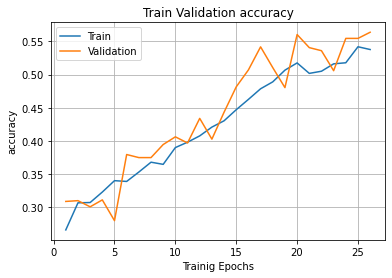

In [44]:
# Train validation accuracy
plot_history(Nadam_hostory.history, False)

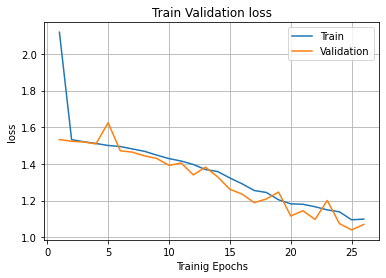

In [45]:
# Train validation loss 
plot_history(Nadam_hostory.history, True)

In [46]:
# Evaluate Network 
# 用 optimizer=Adam epochs=40 batch_size=16 做評估
#顯示訓練成果(分數)

scores = Adam_model.evaluate(x_test, y_test)   
print("Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0)) 

27/27 [==============================] - 0s 2ms/step - loss: 0.3829 - accuracy: 0.9074
Accuracy of testing data = 90.7%


In [47]:
# Make Predictions

#[0:'daisy', 1:'dandelion', 2:'rose', 3:'sunflower', 4:'tulip']
#預測分類數值
pred_digits = np.argmax(Adam_model.predict(x_test), axis=-1)
#實際分類數值
actual_digits = np.argmax(y_test, axis=-1)

27/27 [==============================] - 0s 2ms/step


In [48]:
# 總圖片 4317 * 0.2 = 864 張圖片 分割 進測試集 
# 864 張圖片 中挑 10 張
#建 0 ~ 863 數的 list
pred_list = [i for i in range(len(x_test))]

#打亂 list 排列 並 挑 前10筆 印出測後的結果和正解進行比較
random.shuffle(pred_list)
#print(predictions_list)

# 將測試集的圖檔資料轉回二維
x_test=x_test.reshape(-1, IMG_SIZE , IMG_SIZE)

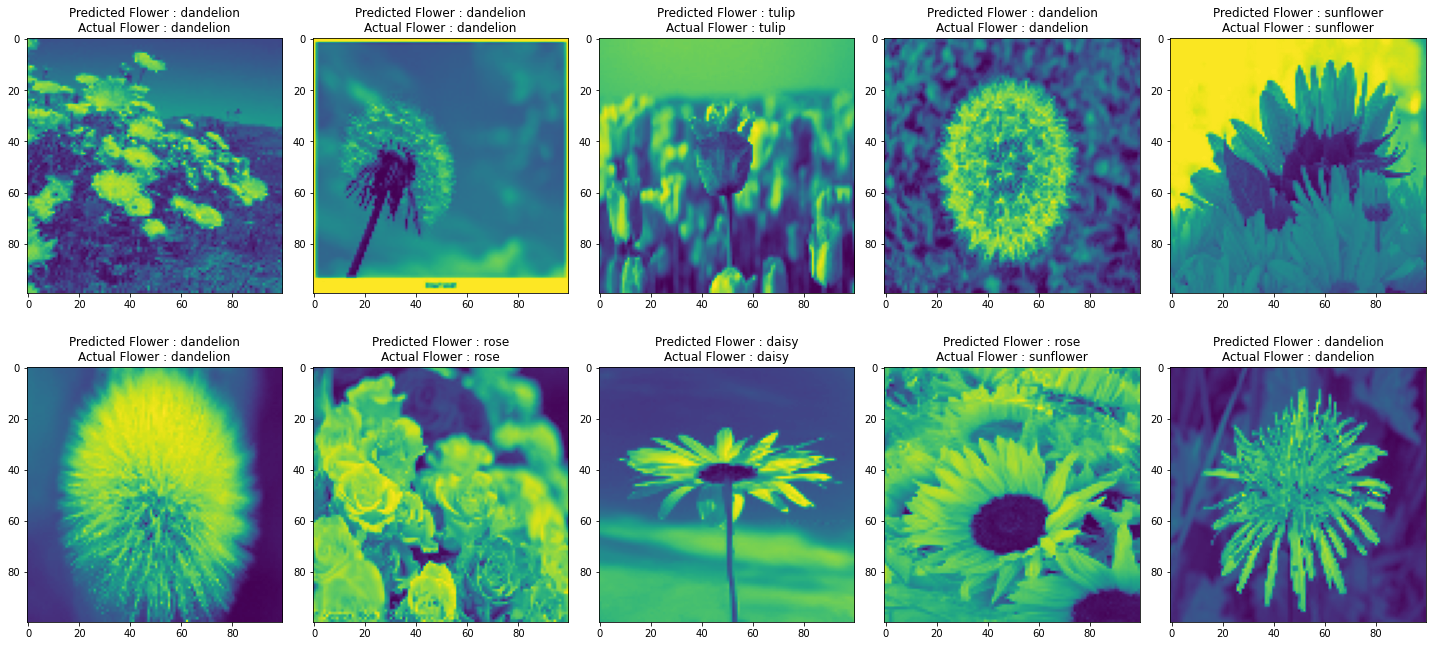

In [49]:
# 印出測試集隨機十筆預測後的結果和正解進行比較
count=0
fig,ax=plt.subplots(row,col) # row=2 col=5
fig.set_size_inches(20,10)
for i in range (row):
    for j in range (col):
        ax[i,j].imshow(x_test[pred_list[count]])
        ax[i,j].set_title("Predicted Flower : "+str(CATEGORIES[pred_digits[pred_list[count]]])+"\n"+"Actual Flower : "+str(CATEGORIES[actual_digits[pred_list[count]]]))
        plt.tight_layout()
        count+=1

classification_report: 

               precision    recall  f1-score   support

       daisy       1.00      0.87      0.93       142
   dandelion       0.91      0.96      0.94       211
        rose       0.73      0.97      0.83       144
   sunflower       0.96      0.93      0.95       169
       tulip       1.00      0.80      0.89       198

    accuracy                           0.91       864
   macro avg       0.92      0.91      0.91       864
weighted avg       0.92      0.91      0.91       864


confusion_matrix: 



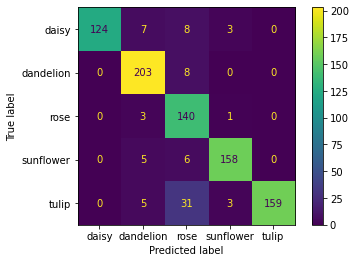

In [50]:
confusion = confusion_matrix(actual_digits, pred_digits)
report = metrics.classification_report(actual_digits, pred_digits, target_names=CATEGORIES)

print("classification_report: \n\n", report)

print("\nconfusion_matrix: \n")
ConfusionMatrixDisplay(confusion,display_labels=CATEGORIES).plot();

